# Transfer learning



In [13]:
# do imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

Get the examples from the "Cats vs. dogs" dataset.

- Train: 80%
- Validation: 10%
- Test: 10%

The images contain images with different shapes and 3 channels.

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteSB1G6N/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


First thing we will do is to resize all images, so they  have a 100 x 100 size. Tensorflow official example uses 160 x 160, but I would like to experiment with smaller values to check the impact of this change.

In [16]:
IMG_SIZE = 100 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

# apply to dataset
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# shuffle the dataset and batch the data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## Create the base model using pre-trained convnets

The base model used here comes from Ternsorflow official examples and uses the MobileNet V2 model developed at Google. 

According to them, "this is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes". 


In [17]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

We have to "freeze" the convolutional base created before to use it as a feature extractor. Then, we add a classifier on top of it and train the top-level classifier. To freeze the model, we set the trainable flag to "False".

In [18]:
base_model.trainable = False

# check model
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

To generate predictions, we use GlobalAveragePooling2D layer and a Dense layer to convert features into a single prediction per image. 




In [21]:
# add layer to create features
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# add a prediction layer
prediction_layer = tf.keras.layers.Dense(1)

# create model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# compile
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# see summary
model.summary()

# train model
initial_epochs = 10

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
582/582 [==============================] - 61s 105ms/step - loss: 0.3345 - accuracy: 0.8427 - val_loss: 0.2202 - val_accuracy: 0.9054
Epoch 2/10
582/582 [==============================] - 58s 99ms/step - loss: 0.1912 - accuracy: 0.9142 - val_loss: 0.1983 - val_accuracy: 0.9153
Epoch 3/10
582/582 [==============================] - 58s 100ms/step - loss: 0.17

Check the loss and the accuracy.

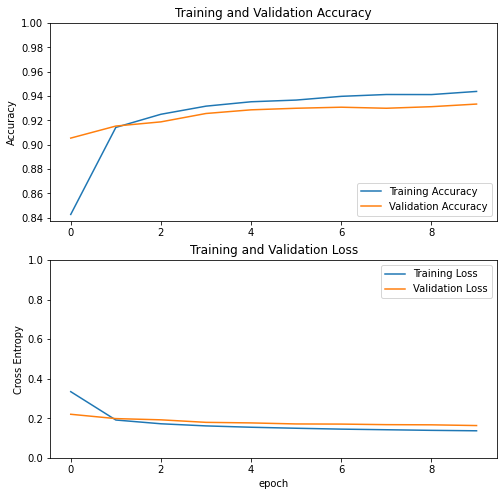

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()